In [1]:
# Extarct dataset from Kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!kaggle datasets download -d salader/dogs-vs-cats

 98% 1.05G/1.06G [00:24<00:00, 52.4MB/s]
100% 1.06G/1.06G [00:24<00:00, 46.4MB/s]


In [3]:
# Unzip the dataset

import zipfile
zip = zipfile.ZipFile('/content/dogs-vs-cats.zip', 'r')
zip.extractall('/content')
zip.close()

In [4]:
import tensorflow
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout
from keras.applications.vgg16 import VGG16

In [6]:
conv_base = VGG16(
    weights='imagenet',
    include_top = False,
    input_shape=(256,256,3)
)

58889256/58889256 [==============================] - 2s 0us/step


In [7]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [13]:
# will use generators to handle large dataset

train_data = keras.utils.image_dataset_from_directory(
    directory = '/content/train',
    labels = 'inferred',
    label_mode = 'int',
    batch_size = 32,
    image_size = (256,256)
)

validation_data = keras.utils.image_dataset_from_directory(
    directory = '/content/test',
    labels = 'inferred',
    label_mode = 'int',
    batch_size = 32,
    image_size = (256,256)
)


Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.


In [14]:
# Normalize the values from 0 to 1 of image which is currently 0 to 255.

def map_image(image, label):
  image = tensorflow.cast(image/255, tensorflow.float32)
  return image, label

train_data = train_data.map(map_image)
validation_data  = validation_data.map(map_image)

In [15]:
type(train_data)

tensorflow.python.data.ops.dataset_ops.MapDataset

CNN Model

In [11]:
model = Sequential()

"""model.add(Conv2D(32, kernel_size=(3,3), padding='valid', activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))
model.add(Conv2D(64, kernel_size=(3,3), padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))
model.add(Conv2D(128, kernel_size=(3,3), padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))"""

model.add(conv_base)
model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [12]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 32768)             0         
                                                                 
 dense_3 (Dense)             (None, 128)               4194432   
                                                                 
 dense_4 (Dense)             (None, 256)               33024     
                                                                 
 dense_5 (Dense)             (None, 1)                 257       
                                                                 
Total params: 18,942,401
Trainable params: 4,227,713
Non-trainable params: 14,714,688
_________________________________________________________________


In [10]:
# Freeze the convulution layer
conv_base.trainable = False

In [16]:
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

In [18]:
logs = model.fit(train_data, epochs=10, validation_data = validation_data)

Epoch 1/10
625/625 [==============================] - 158s 252ms/step - loss: 0.1409 - accuracy: 0.9425 - val_loss: 0.1475 - val_accuracy: 0.9376
Epoch 2/10
625/625 [==============================] - 157s 250ms/step - loss: 0.1013 - accuracy: 0.9593 - val_loss: 0.1782 - val_accuracy: 0.9256
Epoch 3/10
625/625 [==============================] - 157s 250ms/step - loss: 0.0882 - accuracy: 0.9636 - val_loss: 0.1912 - val_accuracy: 0.9334
Epoch 4/10
625/625 [==============================] - 156s 250ms/step - loss: 0.0561 - accuracy: 0.9793 - val_loss: 0.1799 - val_accuracy: 0.9354
Epoch 5/10
625/625 [==============================] - 157s 250ms/step - loss: 0.0400 - accuracy: 0.9849 - val_loss: 0.5847 - val_accuracy: 0.8672
Epoch 6/10
625/625 [==============================] - 156s 249ms/step - loss: 0.0406 - accuracy: 0.9842 - val_loss: 0.2502 - val_accuracy: 0.9244
Epoch 7/10
625/625 [==============================] - 157s 250ms/step - loss: 0.0419 - accuracy: 0.9843 - val_loss: 0.3288 -

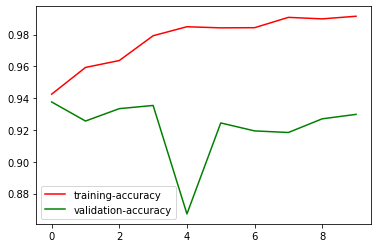

In [19]:
# Plot loss and accuracy graphs

import matplotlib.pyplot as plt

plt.plot(logs.history['accuracy'], color='red', label='training-accuracy')
plt.plot(logs.history['val_accuracy'], color='green', label='validation-accuracy')
plt.legend()
plt.show()

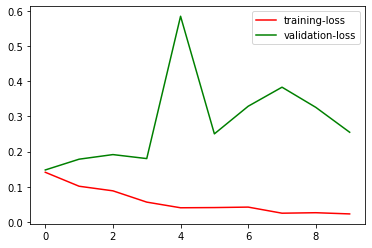

In [20]:
# We can see there is Overfiiting in this.

plt.plot(logs.history['loss'], color='red', label='training-loss')
plt.plot(logs.history['val_loss'], color='green', label='validation-loss')
plt.legend()
plt.show()

Predictions

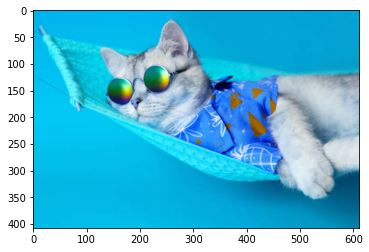

In [21]:
import cv2

test_image = cv2.imread('/content/cat.jpg')

plt.imshow(test_image)

In [22]:
test_image = cv2.resize(test_image, (256,256))

In [23]:
test_image = test_image.reshape(1,256,256,3)

In [24]:
model.predict(test_image)


1/1 [==============================] - 1s 701ms/step


array([[0.]], dtype=float32)

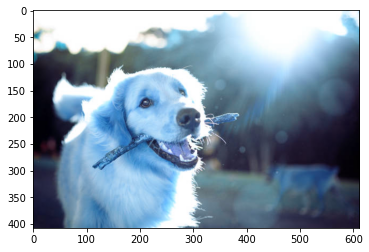

In [25]:
test_image = cv2.imread('/content/dog.jpg')

plt.imshow(test_image)

In [26]:
test_image = cv2.resize(test_image, (256,256))

In [27]:
type(test_image)

numpy.ndarray

In [28]:
test_image = test_image.reshape(1,256,256,3)

In [30]:
model.predict(test_image)


1/1 [==============================] - 0s 17ms/step


array([[1.]], dtype=float32)